<a href="https://colab.research.google.com/github/retuyu88/digitalentkominfo/blob/master/Copy_of_%5B32_3%5D_Pix2Pix_GAN_ADF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src = "https://i.imgur.com/UjutVJd.jpg" align = "center">

# Pix2Pix GAN Models 

This notebook demonstrates image to image translation using conditional GAN's, as described in [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/abs/1611.07004). Using this technique we can colorize black and white photos, convert google maps to google earth, etc. Here, we convert building facades to real buildings.

In example, we will use the [CMP Facade Database](http://cmp.felk.cvut.cz/~tylecr1/facade/), helpfully provided by the [Center for Machine Perception](http://cmp.felk.cvut.cz/) at the [Czech Technical University in Prague](https://www.cvut.cz/). To keep our example short, we will use a preprocessed [copy](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/) of this dataset, created by the authors of the [paper](https://arxiv.org/abs/1611.07004) above.

Below is the output generated after training the model for 200 epochs.

![sample output_1](https://www.tensorflow.org/images/gan/pix2pix_1.png)
![sample output_2](https://www.tensorflow.org/images/gan/pix2pix_2.png)

In [0]:
# import scipy
# from glob import glob
# import numpy as np
# import matplotlib.pyplot as plt
# import imageio
# from PIL import Image
# import cv2 as cv

# class DataLoader():
#     def __init__(self, dataset_name, img_res=(128, 128)):
#         self.dataset_name = dataset_name
#         self.img_res = img_res

#     def load_data(self, batch_size=1, is_testing=False):
#         data_type = "train" if not is_testing else "test"
#         path = glob('./datasets/%s/%s/*' % (self.dataset_name, data_type))

#         batch_images = np.random.choice(path, size=batch_size)

#         imgs_A = []
#         imgs_B = []
#         for img_path in batch_images:
#             img = self.imread(img_path)

#             h, w, _ = img.shape
#             _w = int(w/2)
#             img_A, img_B = img[:, :_w, :], img[:, _w:, :]

#             img_A = cv.resize(img_A, self.img_res, interpolation=cv.INTER_AREA)
#             img_B = cv.resize(img_B, self.img_res, interpolation=cv.INTER_AREA)

#             # If training => do random flip
#             if not is_testing and np.random.random() < 0.5:
#                 img_A = np.fliplr(img_A)
#                 img_B = np.fliplr(img_B)

#             imgs_A.append(img_A)
#             imgs_B.append(img_B)

#         imgs_A = np.array(imgs_A)/127.5 - 1.
#         imgs_B = np.array(imgs_B)/127.5 - 1.

#         return imgs_A, imgs_B

#     def load_batch(self, batch_size=1, is_testing=False):
#         data_type = "train" if not is_testing else "val"
#         path = glob('./datasets/%s/%s/*' % (self.dataset_name, data_type))

#         self.n_batches = int(len(path) / batch_size)

#         for i in range(self.n_batches-1):
#             batch = path[i*batch_size:(i+1)*batch_size]
#             imgs_A, imgs_B = [], []
#             for img in batch:
#                 img = self.imread(img)
#                 h, w, _ = img.shape
#                 half_w = int(w/2)
#                 img_A = img[:, :half_w, :]
#                 img_B = img[:, half_w:, :]

#                 img_A = cv.resize(img_A, self.img_res, interpolation=cv.INTER_AREA)
#                 img_B = cv.resize(img_B, self.img_res, interpolation=cv.INTER_AREA)

#                 if not is_testing and np.random.random() > 0.5:
#                         img_A = np.fliplr(img_A)
#                         img_B = np.fliplr(img_B)

#                 imgs_A.append(img_A)
#                 imgs_B.append(img_B)

#             imgs_A = np.array(imgs_A)/127.5 - 1.
#             imgs_B = np.array(imgs_B)/127.5 - 1.

#             yield imgs_A, imgs_B


#     def imread(self, path):
#         return imageio.imread(path).astype(np.float)

## Import Module

In [0]:

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from PIL import Image

import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os

### Load Data Loader Helper Functions

In [2]:
!wget 'https://raw.githubusercontent.com/adf-telkomuniv/FG_AI_Public/master/others/data_loader.py'

from data_loader import DataLoader


--2019-08-13 03:51:57--  https://raw.githubusercontent.com/adf-telkomuniv/FG_AI_Public/master/others/data_loader.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2546 (2.5K) [text/plain]
Saving to: ‘data_loader.py’

data_loader.py      100%[===================>]   2.49K  --.-KB/s    in 0s      

2019-08-13 03:51:57 (78.3 MB/s) - ‘data_loader.py’ saved [2546/2546]



---
## Load Dataset

In [3]:
!mkdir datasets

!wget -N 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz' -O './datasets/facades.tar.gz'
!mkdir './datasets/facades/'
!tar -zxf './datasets/facades.tar.gz' -C ./datasets/
!rm './datasets/facades.tar.gz'

for details.

--2019-08-13 03:52:03--  https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘./datasets/facades.tar.gz’

./datasets/facades. 100%[===================>]  28.77M  25.3MB/s    in 1.1s    

2019-08-13 03:52:05 (25.3 MB/s) - ‘./datasets/facades.tar.gz’ saved [30168306/30168306]



### Show Example

In [0]:
def load(image_file):
  image = Image.open(image_file)
  image = np.array(image)

  w = image.shape[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = np.array(input_image).astype('float32')
  real_image =  np.array(real_image).astype('float32')

  return input_image, real_image

(-0.5, 255.5, 255.5, -0.5)

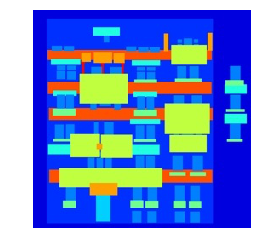

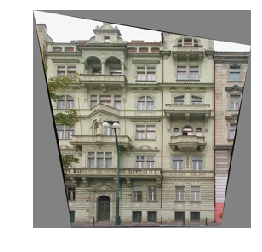

In [5]:
inp, re = load('./datasets/facades/train/100.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.axis('off')
plt.figure()
plt.imshow(re/255.0)
plt.axis('off')

---
## Build Pix2Pix Model

In [0]:
img_shape = (256, 256, 3)
dataset_name = 'facades'
data_loader = DataLoader(dataset_name=dataset_name,
                         img_res=(img_shape[0], img_shape[1]))

# Calculate output shape of D (PatchGAN)
patch = int(img_shape[0] / 2**4)
disc_patch = (patch, patch, 1)

# Number of filters in the first layer of G and D
gf = 64
df = 64

optimizer = Adam(0.0002, 0.5)

### Discriminator Model

  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.

In [0]:
def build_discriminator():

    def d_layer(layer_input, filters, f_size=4, bn=True):
        """Discriminator layer"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    img_A = Input(shape=img_shape)
    img_B = Input(shape=img_shape)

    # Concatenate image and conditioning image by channels to produce input
    combined_imgs = Concatenate(axis=-1)([img_A, img_B])

    d1 = d_layer(combined_imgs, df, bn=False)
    d2 = d_layer(d1, df*2)
    d3 = d_layer(d2, df*4)
    d4 = d_layer(d3, df*8)

    validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model([img_A, img_B], validity)

In [8]:
discriminator = build_discriminator()
discriminator.summary()
discriminator.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

W0813 03:52:26.603366 140526297450368 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256, 256, 6)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 6208        concatenate[0][0]            

### Generator Model

  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).


In [0]:
def build_generator():
  """U-Net Generator"""

  def conv2d(layer_input, filters, f_size=4, bn=True):
      """Layers used during downsampling"""
      d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
      d = LeakyReLU(alpha=0.2)(d)
      if bn:
          d = BatchNormalization(momentum=0.8)(d)
      return d

  def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
      """Layers used during upsampling"""
      u = UpSampling2D(size=2)(layer_input)
      u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
      if dropout_rate:
          u = Dropout(dropout_rate)(u)
      u = BatchNormalization(momentum=0.8)(u)
      u = Concatenate()([u, skip_input])
      return u

  # Image input
  d0 = Input(shape=img_shape)

  # Downsampling
  d1 = conv2d(d0, gf, bn=False)
  d2 = conv2d(d1, gf*2)
  d3 = conv2d(d2, gf*4)
  d4 = conv2d(d3, gf*8)
  d5 = conv2d(d4, gf*8)
  d6 = conv2d(d5, gf*8)
  d7 = conv2d(d6, gf*8)

  # Upsampling
  u1 = deconv2d(d7, d6, gf*8)
  u2 = deconv2d(u1, d5, gf*8)
  u3 = deconv2d(u2, d4, gf*8)
  u4 = deconv2d(u3, d3, gf*4)
  u5 = deconv2d(u4, d2, gf*2)
  u6 = deconv2d(u5, d1, gf)

  u7 = UpSampling2D(size=2)(u6)
  output_img = Conv2D(img_shape[2], kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

  return Model(d0, output_img)

In [10]:
generator = build_generator()
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 128, 128, 64) 3136        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu_4[0][0]              
____________________________________________________________________________________________

### Combine Models

In [0]:
# Input images and their conditioning images
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)

# By conditioning on B generate a fake version of A
fake_A = generator(img_B)

# For the combined model we will only train the generator
discriminator.trainable = False

# Discriminators determines validity of translated images / condition pairs
valid = discriminator([fake_A, img_B])

combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
combined.compile(loss=['mse', 'mae'],
                      loss_weights=[1, 100],
                      optimizer=optimizer)

---
## Training Model

### Sampling Helper Function

In [0]:
def sample_images(epoch, batch_i):
    os.makedirs('images/%s' % dataset_name, exist_ok=True)
    r, c = 3, 3

    imgs_A, imgs_B = data_loader.load_data(batch_size=3, is_testing=True)
    fake_A = generator.predict(imgs_B)

    gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    titles = ['Condition', 'Generated', 'Original']
    fig, axs = plt.subplots(r, c, figsize=(6,6))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i, j].set_title(titles[i])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/%s/%d_%d.png" % (dataset_name, epoch, batch_i))
    plt.rcParams['figure.figsize'] = [15, 5]
    plt.show()
    plt.close()

### Training Function

In [0]:
def train(epochs, batch_size=1, print_every=50):

  start_time = datetime.datetime.now()

  # Adversarial loss ground truths
  valid = np.ones((batch_size,) + disc_patch)
  fake = np.zeros((batch_size,) + disc_patch)

  for epoch in range(epochs):
      for batch_i, (imgs_A, imgs_B) in enumerate(data_loader.load_batch(batch_size)):

          # ---------------------
          #  Train Discriminator
          # ---------------------

          # Condition on B and generate a translated version
          fake_A = generator.predict(imgs_B)

          # Train the discriminators (original images = real / generated = Fake)
          d_loss_real = discriminator.train_on_batch([imgs_A, imgs_B], valid)
          d_loss_fake = discriminator.train_on_batch([fake_A, imgs_B], fake)
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

          # -----------------
          #  Train Generator
          # -----------------

          # Train the generators
          g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

          # If at save interval => save generated image samples
          if batch_i % print_every == 0:
              sample_images(epoch, batch_i)

              elapsed_time = datetime.datetime.now() - start_time
              # Plot the progress
              print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                      batch_i, data_loader.n_batches,
                                                                      d_loss[0], 100*d_loss[1],
                                                                      g_loss[0],
                                                                      elapsed_time))

### Train the Model

In [0]:
train(epochs=50, batch_size=32, print_every=100)

---
## Testing Model

In [0]:
r, c = 3, 3
imgs_A, imgs_B = data_loader.load_data(batch_size=3, is_testing=True)
fake_A = generator.predict(imgs_B)

gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

titles = ['Condition', 'Generated', 'Original']
fig, axs = plt.subplots(r, c, figsize=(10,10))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt])
        axs[i, j].set_title(titles[i])
        axs[i,j].axis('off')
        cnt += 1
plt.show()
plt.close()

<p>Copyright &copy; 2019 <a href=https://www.linkedin.com/in/andityaarifianto/>ADF</a> </p>